In [9]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import logging
from helper import getModelDict
delphesDir = os.path.abspath("./DelphesLLP")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

c = 3e8

FORMAT = '%(levelname)s: %(message)s at %(asctime)s'
logging.basicConfig(format=FORMAT,datefmt='%m/%d/%Y %I:%M:%S %p')
logger = logging.getLogger()

In [10]:
defaultPars = {'figure.figsize': (5, 4),
               'lines.markersize' : 4,
               'axes.titlesize' : 13,
               'font.size' : 13,
               'axes.labelsize' : 16,
               'xtick.labelsize' : 13,
               'ytick.labelsize' : 13,
               'legend.fontsize' : 10,
               "text.usetex": True,
               "font.family": "sans-serif",
               "font.sans-serif": ["Helvetica"],
               'font.family':'Times New Roman', 
               'font.serif':'Times New Roman',
               "savefig.dpi" : 300,
               'contour.linewidth' : 2.0,
               'lines.linewidth' : 2.0,
               'axes.grid' : True,
               'grid.linewidth' : 0.5,
               'grid.color' : 'lightgray',
               'axes.axisbelow' : True
               }
plt.rcParams.update(defaultPars)

### Files to be compared

In [11]:
filesDict = {
                r'Signal' : './pp2chi0chi0J_scan/Events/run_01/ddmH_mS_500_m1_244_dm_90_delphes_events.root',
                # r'Signal (no smearing)' : './pp2chi0chi0J_scan/Events/run_01/ddmH_mS_500_m1_244_dm_90_delphes_events_nosmear.root',
}

modelDict = {}
for key,f in list(filesDict.items()):
    if not os.path.isfile(f):
        print(f'File {f} not found. Skipping.')
        filesDict.pop(key)
    else:
        modelDict[key] = getModelDict(f,verbose=False)

if len(set([tuple(d.items()) for d in modelDict.values()])) > 1:
    print('Several models being used!')
    mDict = None
else:
    mDict = list(modelDict.values())[0]


### Get kinematical variables for each file

In [12]:
L1metStr = r'$E_T^{\rm miss}$ (Hardware Trigger, N-1) (GeV)'
L1njStr = r'$n_{j}$ (Hardware Trigger, N)'
L1pTj1Str = r'Leading jet $E_{T}$ (Hardware Trigger, N) (GeV)'
L1dPhi = r'$\Delta \phi^{min} (MET,j)$ (Hardware Trigger)'
L1metPartonStr = r'$E_T^{\rm miss}$ (Parton Level, N-1) (GeV)'

cols = ['label',L1metStr,L1njStr,L1pTj1Str,L1dPhi,L1metPartonStr]


dataList = []
for label,file in filesDict.items():   
    f = ROOT.TFile(file,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    for ievt in range(nevts):
        tree.GetEntry(ievt)

        # Get parton level MET
        llps = list(tree.llpParticles)
        invisibles = [p for p in tree.llpDirectDaughters 
                      if abs(p.PID) == 4000022]
        invisibles = sorted(invisibles, key = lambda p: p.M1)
        pInvTot = np.zeros(3)
        for illp,llp in enumerate(llps):
            daughter = invisibles[illp]
            decayTime = daughter.T
            if decayTime < 10e-9: # if LLP decays on-time, add its daughter momentum
                pInv = np.array([daughter.Px,daughter.Py,
                                 daughter.Pz])
            else: # add the LLP momentum
                pInv = np.array([llp.Px,llp.Py,
                                llp.Pz])
            pInvTot += pInv
        
        metParton = np.linalg.norm(pInvTot[:2])




        metOnTime = tree.L1METOnTime.At(0)
        jetsDelayed = list(tree.L1JetDelayed)
        jetsDelayed = sorted(jetsDelayed, 
                         key = lambda j: j.PT, reverse=True)

        met = metOnTime.MET
        nj = len(jetsDelayed)
        if nj > 0:
            pTj1 = jetsDelayed[0].PT
            dphi_min = 10000.0
            for j in jetsDelayed[:6]:
                dphi = np.abs(j.Phi-metOnTime.Phi)
                if dphi > np.pi:
                    dphi = 2*np.pi-dphi
                dphi_min = min(dphi,dphi_min)
        else:
            pTj1 = 0.0
            dphi_min = 5.0

        
        
        dataList.append([label,met,nj,pTj1,dphi_min,metParton])
    f.Close()
df = pd.DataFrame(columns=cols,data=dataList)
        

### Add Tobias curves

In [13]:
tobiasCurves = {L1metStr : './B2TF-Tobias/resutls/l1_met.csv',
                L1njStr : './B2TF-Tobias/resutls/l1_nj.csv',
                L1pTj1Str : './B2TF-Tobias/resutls/l1_et.csv',
                L1dPhi : './B2TF-Tobias/resutls/l1_del_phi.csv',
                L1metPartonStr : './B2TF-Tobias/resutls/l1_met.csv',
                }

## Plot Distributions

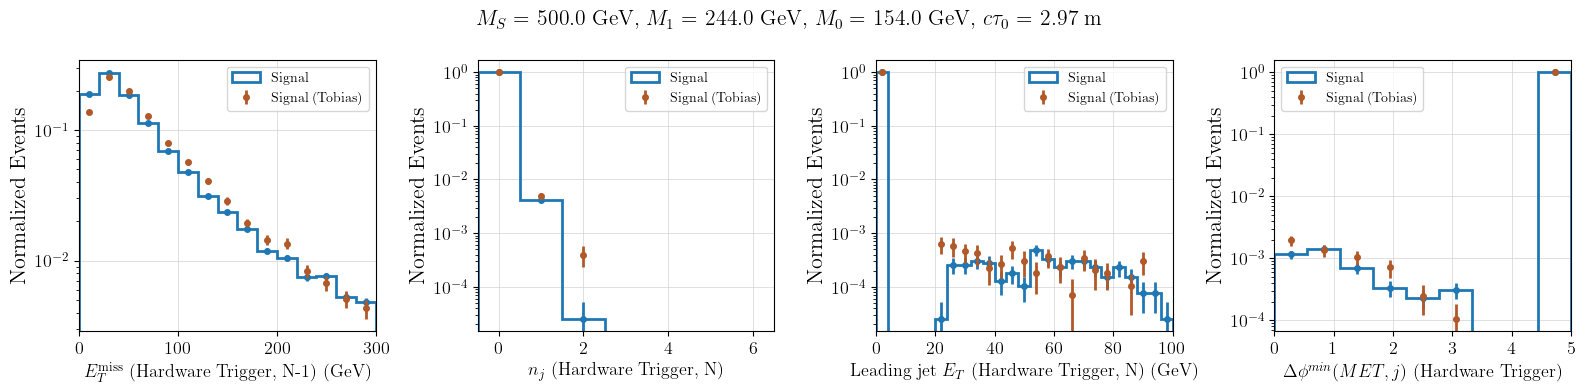

In [14]:
plot_variables = [c for c in df.columns if c not in ['label',L1metPartonStr]]

colors = plt.colormaps['Paired'].colors[1::2]

ncols = len(plot_variables)

nrows = 1
fig,axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=(4*ncols,4.0*nrows))

binsDict = {L1metStr : np.arange(0.,300.,20.), 
            L1njStr : np.arange(-0.5,5.,1.),
            L1pTj1Str : np.arange(0.,100.,5.),
            L1dPhi : np.linspace(0.0,5.0,20),
            L1metPartonStr : np.arange(0.,300.,20.), 
            }


for i,var in enumerate(plot_variables):
    
    # ax = axes[0,i]
    ax = axes[i]
    ymax = 0.0

    # Add Tobias curve if found
    if var in tobiasCurves:
        tobiasData = np.genfromtxt(tobiasCurves[var],delimiter=',',names=True)
        ax.errorbar(tobiasData['bin_center'],
                    tobiasData['normalized_count'],
                    tobiasData['error'],
                    linewidth=2,                    
                    fmt="o",
                    color=colors[-1],
                    zorder=10,
                    label='Signal (Tobias)'
                    )
        bin_centers = tobiasData['bin_center']
        bins = list(tobiasData['bin_left_edge'])
        bins.append(tobiasData['bin_right_edge'][-1])
    else:
        v_max, v_min = df[var].max(),df[var].min()
        if var in binsDict:
            bins = binsDict[var]
        else:
            bins = np.linspace(v_min,v_max,25)
        # print(var,bins)
        bin_centers = 0.5*(bins[1:] + bins[:-1])
        

    for j,label in enumerate(df['label'].unique()):
        if 'Signal' in label:
            ls = 'solid'
        else:
            ls = 'dashed'
        color = colors[j]
        data = df[df['label'] == label]
        # print('b2=',bins)
        y,_ = np.histogram(data[var], bins=bins)
        yerr = np.sqrt(y)
        norm = sum(y)
        y = y/norm
        ymax = max(ymax,y.max())
        yerr = yerr/norm
        # print('bc=',bin_centers)
        _,_,p = ax.hist(bin_centers,weights=y,bins=bins,histtype='step',
                linewidth=2,linestyle=ls,label=label,color=color)
        ax.errorbar(bin_centers,y,yerr = yerr,
                        # marker = '.',
                        color=color,
                        # color=p[-1].get_facecolor(),
                        # drawstyle = 'steps-mid',label=label,
                        linewidth=2,
                        # linestyle=ls,
                        fmt="o")
        
    
        # Plot ratios
        if j == 0:
            y0 = y
            y0Err = yerr
            r_y = np.ones(len(y))
            r_error = np.zeros(len(y))
        else:            
            r_y = np.divide(y,y0)
            r_error = r_y*np.sqrt((yerr/y)**2 + (y0Err/y0)**2)
        

    
        
    
    ax.set_ylabel('Normalized Events')
    ax.set_yscale('log')
    ax.set_xlim(min(bins),max(bins))
    # dx = bin_centers[1]-bin_centers[0]
    # if len(bin_centers) <= 6:
        # ax.xaxis.set_ticks(bin_centers)
    # else:
        # ax.xaxis.set_ticks(bin_centers[::2])
    if i >= 0:
        ax.legend()
    
    ax.set_xlabel(var,fontsize=13)

if mDict:
    fig.suptitle(r"$M_{S} =$ %1.1f GeV, $M_{1} = $ %1.1f GeV, $M_0 = $ %1.1f GeV, $c \tau_0$ = %1.2f m" %(mDict['mS'],mDict['m1'],mDict['m0'],c*mDict['tau']))
plt.tight_layout()
plt.show()

/tmp/ipykernel_15551/4027131771.py:81: RuntimeWarning: invalid value encountered in divide
  ddy = np.where(dy_error > 0., dy/dy_error,0.0)


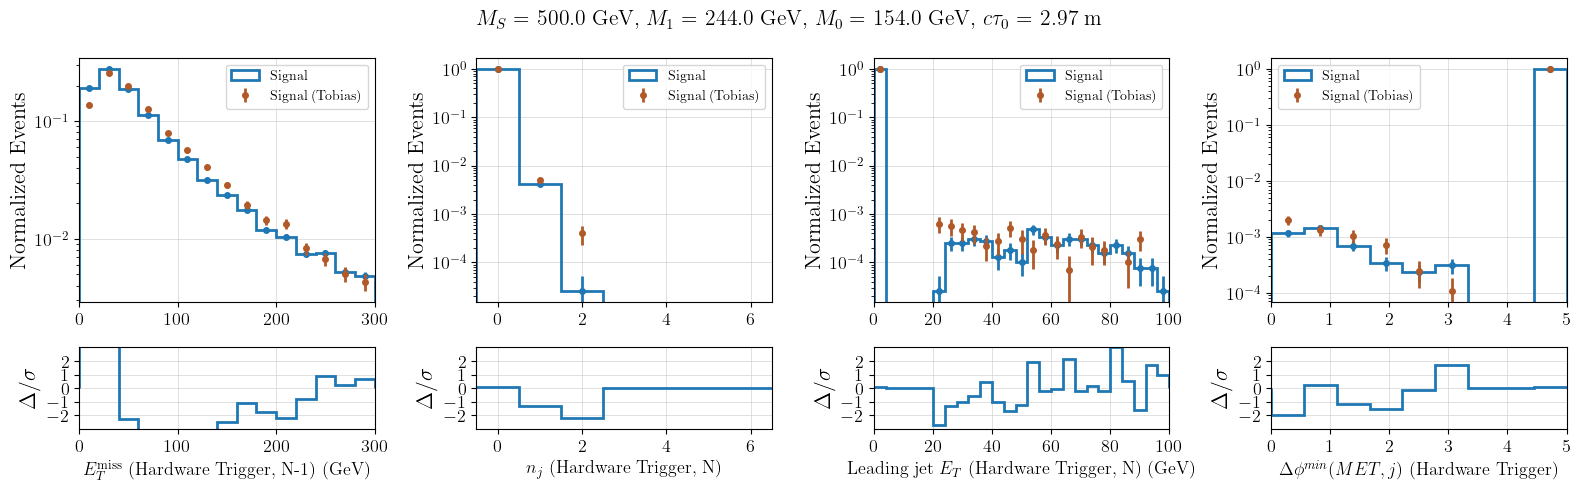

In [15]:
ncols = len(plot_variables)
nrows = 2
fig,axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=(4*ncols,2.5*nrows),
                        sharex=False, gridspec_kw = {'height_ratios':[3, 1]})
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)



for i,var in enumerate(plot_variables):
    v_max, v_min = df[var].max(),df[var].min()
    if var in binsDict:
        bins = binsDict[var]
    else:
        bins = np.linspace(v_min,v_max,25)
    # print(var,bins)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax = axes[0,i]
    ymax = 0.0

    # Add Tobias curve if found
    if var in tobiasCurves:
        tobiasData = np.genfromtxt(tobiasCurves[var],delimiter=',',names=True)
        ax.errorbar(tobiasData['bin_center'],
                    tobiasData['normalized_count'],
                    tobiasData['error'],
                    linewidth=2,                    
                    fmt="o",
                    color=colors[-1],
                    zorder=10,
                    label='Signal (Tobias)'
                    )
        y0 = tobiasData['normalized_count']
        y0Err = tobiasData['error']
        bin_centers = tobiasData['bin_center']
        bins = list(tobiasData['bin_left_edge'])
        bins.append(tobiasData['bin_right_edge'][-1])
    else:
        v_max, v_min = df[var].max(),df[var].min()
        if var in binsDict:
            bins = binsDict[var]
        else:
            bins = np.linspace(v_min,v_max,25)
        # print(var,bins)
        bin_centers = 0.5*(bins[1:] + bins[:-1])

    for j,label in enumerate(df['label'].unique()):
        if 'Signal' in label:
            ls = 'solid'
        else:
            ls = 'dashed'
        color = colors[j]
        data = df[df['label'] == label]
        # print('b2=',bins)
        y,_ = np.histogram(data[var], bins=bins)
        yerr = np.sqrt(y)
        norm = sum(y)
        y = y/norm
        ymax = max(ymax,y.max())
        yerr = yerr/norm
        # print('bc=',bin_centers)
        _,_,p = ax.hist(bin_centers,weights=y,bins=bins,histtype='step',
                linewidth=2,linestyle=ls,label=label,color=color)
        ax.errorbar(bin_centers,y,yerr = yerr,
                        # marker = '.',
                        color=color,
                        # color=p[-1].get_facecolor(),
                        # drawstyle = 'steps-mid',label=label,
                        linewidth=2,
                        # linestyle=ls,
                        fmt="o")
        
    
        # Plot ratios
        # r_y = np.divide(y,y0)
        # r_error = r_y*np.sqrt((yerr/y)**2 + (y0Err/y0)**2)
        # axes[1,i].errorbar(bin_centers,r_y,yerr = r_error,marker = '.',drawstyle = 'steps-mid',
        #             label=label,linewidth=2,linestyle=ls,color=color)
        # Plot diff
        dy = y-y0
        dy_error = np.sqrt(yerr**2 + y0Err**2)
        ddy = np.where(dy_error > 0., dy/dy_error,0.0)
        axes[1,i].hist(bin_centers,weights=ddy,bins=bins,histtype='step',
                        linewidth=2,linestyle=ls,label=label,color=color)
    

    
        
    
    ax.set_ylabel('Normalized Events')
    ax.set_yscale('log')
    ax.set_xlim(min(bins),max(bins))
    # dx = bin_centers[1]-bin_centers[0]
    # if len(bin_centers) <= 6:
        # ax.xaxis.set_ticks(bin_centers)
    # else:
        # ax.xaxis.set_ticks(bin_centers[::2])
    if i >= 0:
        ax.legend()

    axes[1,i].set_xlabel(var,fontsize=13)
    # axes[1,i].set_ylabel('Ratio')
    axes[1,i].set_ylabel(r'$\Delta/\sigma$')
    axes[1,i].set_yticks([-2.0,-1.0,0.0,1.0,2.0])
    axes[1,i].set_ylim(-3.0,3.0)
    axes[1,i].set_xlim(min(bins),max(bins))
    

if mDict:
    fig.suptitle(r"$M_{S} =$ %1.1f GeV, $M_{1} = $ %1.1f GeV, $M_0 = $ %1.1f GeV, $c \tau_0$ = %1.2f m" %(mDict['mS'],mDict['m1'],mDict['m0'],c*mDict['tau']))
plt.tight_layout()
plt.show()